Assignment 2 - Big Data with H2O

**Regression**

In [2]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import matplotlib.pyplot as plt

Set up some parameters for the analysis.  

In [3]:
data_path=None
all_variables=None
test_path=None
target=None
nthreads=1 
min_mem_size=6 
run_time=333
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0 

The next sections contains helper functions for automating analysis.             

In [4]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(run_id,analysis,target,run_time,classification,scale,model,balance,balance_threshold,name,nthreads,min_mem_size):
  m_data={}
  m_data['run_id'] =run_id
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [5]:
data_path='C:/Users/Leo/Downloads/Summary of Weather.csv'

In [6]:
data_path = os.path.join(os.path.abspath(os.curdir),data_path)

In [7]:
all_variables=None

In [8]:
run_id=alphabet(9)
# run_id to std out
print (run_id) 

HihnZMlGR


In [9]:
server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir) 

In [10]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:30866..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from C:\Users\Leo\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Leo\AppData\Local\Temp\tmp_dlupvhy
  JVM stdout: C:\Users\Leo\AppData\Local\Temp\tmp_dlupvhy\h2o_Leo_started_from_python.out
  JVM stderr: C:\Users\Leo\AppData\Local\Temp\tmp_dlupvhy\h2o_Leo_started_from_python.err
  Server is running at http://127.0.0.1:30866
Connecting to H2O server at http://127.0.0.1:30866... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,1 month and 9 days
H2O cluster name:,H2O_from_python_Leo_fcmdpx
H2O cluster total nodes:,1
H2O cluster free memory:,5.750 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [11]:
# meta data
meta_data = set_meta_data(run_id,analysis,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,nthreads,min_mem_size)
print(meta_data)  

{'run_id': 'HihnZMlGR', 'start_time': 1540966342.5212, 'target': None, 'max_models': 9, 'run_time': 333, 'scale': False, 'classification': False, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1540966342.5212, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [12]:
print(data_path)

C:/Users/Leo/Downloads/Summary of Weather.csv


In [13]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [14]:
df.head()

STA,Precip,SNF,MEA,MIN,MinTemp,MeanTemp,Snowfall,MAX,YR,MO,DA,PRCP,MaxTemp
10001,1.016,0,75,72,22.2222,23.8889,0,78,42,7,1,0.04,25.5556
10001,0,0,78,71,21.6667,25.5556,0,84,42,7,2,0,28.8889
10001,2.54,0,76,72,22.2222,24.4444,0,79,42,7,3,0.1,26.1111
10001,2.54,0,76,72,22.2222,24.4444,0,80,42,7,4,0.1,26.6667
10001,0,0,76,71,21.6667,24.4444,0,80,42,7,5,0,26.6667
10001,0,0,76,71,21.6667,24.4444,0,80,42,7,6,0,26.6667
10001,nan,0,78,73,22.7778,25.5556,0,83,42,7,7,nan,28.3333
10001,3.556,0,76,72,22.2222,24.4444,0,80,42,7,8,0.14,26.6667
10001,nan,0,77,73,22.7778,25,0,81,42,7,9,nan,27.2222
10001,3.556,0,74,71,21.6667,23.3333,0,78,42,7,10,0.14,25.5556


In [15]:
df.describe()

Rows:119040
Cols:14




,STA,Precip,SNF,MEA,MIN,MinTemp,MeanTemp,Snowfall,MAX,YR,MO,DA,PRCP,MaxTemp
type,int,real,real,int,int,real,real,real,int,int,int,int,real,real
mins,10001.0,0.0,0.0,-32.0,-37.0,-38.33333333,-35.55555556,0.0,-28.0,40.0,1.0,1.0,0.0,-33.33333333
mean,29659.435794690835,3.7539167245104497,0.009667071193977892,72.64484317794529,64.27380831899599,17.7895105285945,22.411631011521248,0.2455436083270395,81.00374474975959,43.80528393817209,6.7260164650537595,15.79753024193548,0.1506372378057895,27.045110887087183
maxs,82506.0,307.34,3.4,104.0,94.0,34.44444444,40.0,86.36,122.0,45.0,12.0,31.0,12.1,50.0
sigma,20953.209401551845,11.566633187774938,0.10340945231416457,14.211081548214434,14.481497830536693,8.33457184977137,8.297982193882994,2.626600088779785,14.869361066103625,1.136718272872706,3.425560596772453,8.79454073402518,0.459275437383152,8.71781664854926
zeros,0,64267,115690,33,28,500,247,115690,15,0,0,0,62335,181
missing,0,16753,1207,498,468,0,0,1207,474,0,0,0,18685,0
0,10001.0,1.016,0.0,75.0,72.0,22.22222222,23.88888889,0.0,78.0,42.0,7.0,1.0,0.04,25.55555556
1,10001.0,0.0,0.0,78.0,71.0,21.66666667,25.55555556,0.0,84.0,42.0,7.0,2.0,0.0,28.88888889
2,10001.0,2.54,0.0,76.0,72.0,22.22222222,24.44444444,0.0,79.0,42.0,7.0,3.0,0.1,26.11111111


describe()[source]
Generate an in-depth description of this H2OFrame.

The description is a tabular print of the type, min, max, sigma, number of zeros, and number of missing elements for each H2OVec in this H2OFrame.

Returns:	None (print to stdout) 

In [16]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
  target=df.columns[-1]   
y = target

In [17]:
print(y)

MaxTemp


In [18]:
print(all_variables)

None


In [19]:
if all_variables is not None:
  ivd=get_all_variables_csv(all_variables)
  print(ivd)    
  X=check_all_variables(df,ivd,y)
  print(X)

In [20]:
df.describe()

Rows:119040
Cols:14




,STA,Precip,SNF,MEA,MIN,MinTemp,MeanTemp,Snowfall,MAX,YR,MO,DA,PRCP,MaxTemp
type,int,real,real,int,int,real,real,real,int,int,int,int,real,real
mins,10001.0,0.0,0.0,-32.0,-37.0,-38.33333333,-35.55555556,0.0,-28.0,40.0,1.0,1.0,0.0,-33.33333333
mean,29659.435794690835,3.7539167245104497,0.009667071193977892,72.64484317794529,64.27380831899599,17.7895105285945,22.411631011521248,0.2455436083270395,81.00374474975959,43.80528393817209,6.7260164650537595,15.79753024193548,0.1506372378057895,27.045110887087183
maxs,82506.0,307.34,3.4,104.0,94.0,34.44444444,40.0,86.36,122.0,45.0,12.0,31.0,12.1,50.0
sigma,20953.209401551845,11.566633187774938,0.10340945231416457,14.211081548214434,14.481497830536693,8.33457184977137,8.297982193882994,2.626600088779785,14.869361066103625,1.136718272872706,3.425560596772453,8.79454073402518,0.459275437383152,8.71781664854926
zeros,0,64267,115690,33,28,500,247,115690,15,0,0,0,62335,181
missing,0,16753,1207,498,468,0,0,1207,474,0,0,0,18685,0
0,10001.0,1.016,0.0,75.0,72.0,22.22222222,23.88888889,0.0,78.0,42.0,7.0,1.0,0.04,25.55555556
1,10001.0,0.0,0.0,78.0,71.0,21.66666667,25.55555556,0.0,84.0,42.0,7.0,2.0,0.0,28.88888889
2,10001.0,2.54,0.0,76.0,72.0,22.22222222,24.44444444,0.0,79.0,42.0,7.0,3.0,0.1,26.11111111


In [21]:
# independent variables

X = []  
if all_variables is None:
  X=get_independent_variables(df, target)  
else: 
  ivd=get_all_variables_csv(all_variables)    
  X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

In [22]:
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True

In [23]:
print(classification)

False


In [24]:
# Force target to be factors
# Only 'int' or 'string' are allowed for asfactor(), got Target (Total orders):real 

if classification:
    df[y] = df[y].asfactor()

In [25]:
def check_y(y,df):
  ok=False
  C = [name for name in df.columns if name == y]
  for key, val in df.types.items():
    if key in C:
      if val in ['real','int','enum']:        
        ok=True         
  return ok, val   

In [26]:
ok,val=check_y(y,df)

In [27]:
print(val)

real


In [28]:
print(ok)

True


In [29]:
if val=='enum':
    print(df[y].levels())

In [30]:
df.describe()

Rows:119040
Cols:14




,STA,Precip,SNF,MEA,MIN,MinTemp,MeanTemp,Snowfall,MAX,YR,MO,DA,PRCP,MaxTemp
type,int,real,real,real,real,real,real,real,real,int,int,int,real,real
mins,10001.0,0.0,0.0,-32.0,-37.0,-38.33333333,-35.55555556,0.0,-28.0,40.0,1.0,1.0,0.0,-33.33333333
mean,29659.435794690835,3.7539167245104474,0.009667071193977915,72.64484317794533,64.273808318996,17.7895105285945,22.411631011521248,0.24554360832703911,81.00374474975966,43.80528393817209,6.7260164650537595,15.79753024193548,0.1506372378057894,27.045110887087183
maxs,82506.0,307.34,3.4,104.0,94.0,34.44444444,40.0,86.36,122.0,45.0,12.0,31.0,12.1,50.0
sigma,20953.209401551845,10.721867249480866,0.10288385475692832,14.181324342925253,14.453002902974077,8.33457184977137,8.297982193882994,2.6132499108259792,14.839727469916907,1.136718272872706,3.425560596772453,8.79454073402518,0.4216925498868997,8.71781664854926
zeros,0,64267,115690,33,28,500,247,115690,15,0,0,0,62335,181
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,10001.0,1.016,0.0,75.0,72.0,22.22222222,23.88888889,0.0,78.0,42.0,7.0,1.0,0.04,25.55555556
1,10001.0,0.0,0.0,78.0,71.0,21.66666667,25.55555556,0.0,84.0,42.0,7.0,2.0,0.0,28.88888889
2,10001.0,2.54,0.0,76.0,72.0,22.22222222,24.44444444,0.0,79.0,42.0,7.0,3.0,0.1,26.11111111


In [31]:
allV=get_variables_types(df)
allV

{'DA': 'int',
 'MAX': 'int',
 'MEA': 'int',
 'MIN': 'int',
 'MO': 'int',
 'MaxTemp': 'real',
 'MeanTemp': 'real',
 'MinTemp': 'real',
 'PRCP': 'real',
 'Precip': 'real',
 'SNF': 'real',
 'STA': 'int',
 'Snowfall': 'real',
 'YR': 'int'}

In [32]:
meta_data['variables']=allV

In [33]:
# split into training and test for showing how to predict
train, test = df.split_frame([0.9])

In [34]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [35]:
model_start_time = time.time()

In [36]:
aml.train(x=X,y=y,training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [40]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [41]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [42]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,GBM_grid_0_AutoML_20181031_021306_model_0,0.012216,0.110524,0.012216,0.023999,NaN
1,StackedEnsemble_BestOfFamily_0_AutoML_20181031...,0.032583,0.180508,0.032583,0.027420,NaN
2,StackedEnsemble_AllModels_0_AutoML_20181031_02...,0.038215,0.195487,0.038215,0.030942,NaN
3,XRT_0_AutoML_20181031_021306,0.089691,0.299484,0.089691,0.042203,NaN
4,GBM_grid_0_AutoML_20181031_021306_model_1,0.090853,0.301418,0.090853,0.051338,NaN
5,GBM_grid_0_AutoML_20181031_021306_model_2,0.099071,0.314755,0.099071,0.065219,NaN
6,DRF_0_AutoML_20181031_021306,0.123796,0.351846,0.123796,0.044293,NaN
7,GBM_grid_0_AutoML_20181031_021306_model_3,0.126812,0.356107,0.126812,0.059451,NaN
8,GLM_grid_0_AutoML_20181031_021306_model_0,0.413681,0.643180,0.413681,0.140672,NaN


In [43]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [44]:
mod_best._id

'GBM_grid_0_AutoML_20181031_021306_model_0'

In [45]:
# Get stacked ensemble  
se=get_stacked_ensemble(model_set)

In [46]:
print(se)

StackedEnsemble_BestOfFamily_0_AutoML_20181031_021306


In [47]:
if se is not None:
  mod_best=h2o.get_model(se)

In [48]:
dir(mod_best)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bc',
 '_bcin',
 '_check_targets',
 '_compute_algo',
 '_estimator_type',
 '_future',
 '_get_metrics',
 '_have_mojo',
 '_have_pojo',
 '_id',
 '_is_xvalidated',
 '_job',
 '_keyify_if_h2oframe',
 '_make_model',
 '_metrics_class',
 '_model_json',
 '_parms',
 '_plot',
 '_requires_training_frame',
 '_resolve_model',
 '_verify_training_frame_params',
 '_xval_keys',
 'actual_params',
 'aic',
 'algo',
 'auc',
 'base_models',
 'biases',
 'catoffsets',
 'coef',
 'coef_norm',
 'cross_validation_fold_assignment',
 'cross_validation_holdout_predictions',
 'cross_validation_metrics_summary',
 'cross_validation_models',


In [49]:
mod_best._id

'StackedEnsemble_BestOfFamily_0_AutoML_20181031_021306'

In [50]:
mod_best._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics>

In [51]:
type(mod_best)

h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator

In [52]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181031_021306
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.002963464005625805
RMSE: 0.05443770757136825
MAE: 0.016037717059560523
RMSLE: NaN
R^2: 0.9999609586156382
Mean Residual Deviance: 0.002963464005625805
Null degrees of freedom: 85765
Residual degrees of freedom: 85762
Null deviance: 6510129.137606689
Residual deviance: 254.16445390650276
AIC: -255874.52111248107

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.08112006600243214
RMSE: 0.28481584577131963
MAE: 0.02606349505844524
RMSLE: NaN
R^2: 0.9989352010588533
Mean Residual Deviance: 0.08112006600243214
Null degrees of freedom: 21454
Residual degrees of freedom: 21451
Null deviance: 1634527.7640473982
Residual deviance: 1740.4310160821815
AIC: 7005.448683206883

ModelMetricsRegressionGLM: stackedensemble
** R

In [53]:
bm=stackedensemble_df(aml_leaderboard_df)

In [54]:
bm

['GBM_grid_0_AutoML_20181031_021306_model_0',
 'GLM_grid_0_AutoML_20181031_021306_model_0',
 'DRF_0_AutoML_20181031_021306',
 'XRT_0_AutoML_20181031_021306']

In [55]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,GBM_grid_0_AutoML_20181031_021306_model_0,0.012216,0.110524,0.012216,0.023999,NaN
1,StackedEnsemble_BestOfFamily_0_AutoML_20181031...,0.032583,0.180508,0.032583,0.027420,NaN
2,StackedEnsemble_AllModels_0_AutoML_20181031_02...,0.038215,0.195487,0.038215,0.030942,NaN
3,XRT_0_AutoML_20181031_021306,0.089691,0.299484,0.089691,0.042203,NaN
4,GBM_grid_0_AutoML_20181031_021306_model_1,0.090853,0.301418,0.090853,0.051338,NaN
5,GBM_grid_0_AutoML_20181031_021306_model_2,0.099071,0.314755,0.099071,0.065219,NaN
6,DRF_0_AutoML_20181031_021306,0.123796,0.351846,0.123796,0.044293,NaN
7,GBM_grid_0_AutoML_20181031_021306_model_3,0.126812,0.356107,0.126812,0.059451,NaN
8,GLM_grid_0_AutoML_20181031_021306_model_0,0.413681,0.643180,0.413681,0.140672,NaN


In [56]:
#  Get best_models and coef_norm()
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
  if 'Intercept' in best_models.keys():
    del best_models['Intercept']
  bm=list(best_models.keys())
else:
  best_models={}
  bm=stackedensemble_df(aml_leaderboard_df)   
  for b in bm:   
    best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [57]:
bm

['GBM_grid_0_AutoML_20181031_021306_model_0',
 'XRT_0_AutoML_20181031_021306',
 'DRF_0_AutoML_20181031_021306',
 'GLM_grid_0_AutoML_20181031_021306_model_0',
 'StackedEnsemble_BestOfFamily_0_AutoML_20181031_021306']

In [58]:
# Best of Family leaderboard

aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]


In [59]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,GBM_grid_0_AutoML_20181031_021306_model_0,0.012216,0.110524,0.012216,0.023999,NaN
1,StackedEnsemble_BestOfFamily_0_AutoML_20181031...,0.032583,0.180508,0.032583,0.027420,NaN
3,XRT_0_AutoML_20181031_021306,0.089691,0.299484,0.089691,0.042203,NaN
6,DRF_0_AutoML_20181031_021306,0.123796,0.351846,0.123796,0.044293,NaN
8,GLM_grid_0_AutoML_20181031_021306_model_0,0.413681,0.643180,0.413681,0.140672,NaN


In [60]:
# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [61]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

GBM_grid_0_AutoML_20181031_021306_model_0


In [62]:
mod_best=h2o.get_model(top)
print(mod_best._id)
print(mod_best.algo)

GBM_grid_0_AutoML_20181031_021306_model_0
gbm


In [63]:
meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

In [64]:
meta_data['models']=bm

In [65]:
models_path=os.path.join(run_dir,'models')
for mod in bm:
  try:   
    m=h2o.get_model(mod) 
    h2o.save_model(m, path = models_path)
  except:    
    pass    

In [66]:
print(models_path)

C:\Users\Leo\Desktop\CSYE_7245-master\BDIA Assignemnt 2\HihnZMlGR\models


In [67]:
# GBM
 
mod,mod_id=get_model_by_algo("GBM",best_models)
if mod is not None:
    try:     
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
    except:
        pass   
    try:     
        stats_gbm={}
        stats_gbm=gbm_stats(mod)
        n=run_id+'_gbm_stats.json'
        dict_to_json(stats_gbm,n)
        print(stats_gbm)
    except:
        pass        

{'algo': 'gbm', 'model_id': 'GBM_grid_0_AutoML_20181031_021306_model_0', 'varimp': [('MeanTemp', 12960830.0, 1.0, 0.4111310543933829), ('MAX', 12641755.0, 0.9753815920739644, 0.4010096623852655), ('MEA', 4165875.25, 0.32142040671777966, 0.13214591071743073), ('MinTemp', 1556738.0, 0.12011098054677054, 0.049381354076416875), ('MIN', 176828.15625, 0.013643274099729725, 0.005609173665999813), ('STA', 15087.1533203125, 0.0011640576506529675, 0.00047858024928763864), ('YR', 2765.450927734375, 0.00021336989434583858, 8.772298963820932e-05), ('DA', 1930.7884521484375, 0.0001489710498593406, 6.124662480275992e-05), ('Precip', 1725.3968505859375, 0.00013312394735413838, 5.473138884071611e-05), ('Snowfall', 571.26171875, 4.4076013553915914e-05, 1.8121017925878485e-05), ('PRCP', 538.1204223632812, 4.151897851937578e-05, 1.7069741416007183e-05), ('MO', 135.66700744628906, 1.046746292068402e-05, 4.30349906740446e-06), ('SNF', 33.707923889160156, 2.600753492574176e-06, 1.069250525619294e-06)]}


In [68]:
# DeepLearning

mod,mod_id=get_model_by_algo("Dee",best_models)


In [69]:
if mod is not None:
    try:    
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_dl_scoring_history.csv') 
    except:
        pass 
    try:
        stats_dl={}
        stats_dl=dl_stats(mod)
        n=run_id+'_dl_stats.json'
        dict_to_json(stats_dl,n)
        print(stats_dl)
    except:
        pass    
    try:
        cf=mod.confusion_matrix()    
        cf_df.to_csv(run_id+'_dl_confusion_matrix.csv')
    except:
        pass       

In [70]:
# DRF

mod,mod_id=get_model_by_algo("DRF",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_drf_scoring_history.csv') 
    except:
         pass  
    try: 
         stats_drf={}
         stats_drf=drf_stats(mod)
         n=run_id+'_drf_stats.json'
         dict_to_json(stats_drf,n)
         print(stats_drf)
    except:
         pass     

In [71]:
# XRT

mod,mod_id=get_model_by_algo("XRT",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_xrt_scoring_history.csv')
    except:
         pass     
    try:        
         stats_xrt={}
         stats_xrt=xrt_stats(mod)
         n=run_id+'_xrt_stats.json'
         dict_to_json(stats_xrt,n)
         print(stats_xrt)
    except:
         pass     

In [72]:
# GLM

mod,mod_id=get_model_by_algo("GLM",best_models)
if mod is not None:
    try:     
         stats_glm={}
         stats_glm=glm_stats(mod)
         n=run_id+'_glm_stats.json'
         dict_to_json(stats_glm,n)
         print(stats_glm)
    except:
         pass     

{'algo': 'glm', 'model_id': 'GLM_grid_0_AutoML_20181031_021306_model_0', 'coef': {'Intercept': 0.4449032065300713, 'STA': 4.2951654874544894e-07, 'Precip': -0.023057872680400736, 'SNF': 0.41609085105795807, 'MEA': -0.1453981880045432, 'MIN': -0.2562749712706765, 'MinTemp': 0.1321976188218823, 'MeanTemp': 0.9365418568031056, 'Snowfall': -0.017311085255573424, 'MAX': 0.3634889005053677, 'YR': 0.019000828083392384, 'MO': 0.0002094895163720759, 'DA': 0.00019591443222679173, 'PRCP': 0.5714085573567832}, 'coef_norm': {'Intercept': 27.060626199956506, 'STA': 0.008993203371429793, 'Precip': -0.24933408449782, 'SNF': 0.04276584522792883, 'MEA': -2.059229202286777, 'MIN': -3.6987773169564733, 'MinTemp': 1.100968858724858, 'MeanTemp': 7.76480508946561, 'Snowfall': -0.04519255602106722, 'MAX': 5.387794669831835, 'YR': 0.021578153756971367, 'MO': 0.0007188263098997643, 'DA': 0.0017257924545968902, 'PRCP': 0.24302347670379926}}


In [73]:
predictions_df=predictions_test(mod_best,test,run_id)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [74]:
predictions_df.head()

predict
26.6692
28.3342
24.4773
26.1288
27.2271
31.1841
29.4333
27.7843
30.5531
32.2314


In [75]:
predictions_df.describe()

Rows:11819
Cols:1




,predict
type,real
mins,-32.1074788343809
mean,26.94578164409437
maxs,49.23777763383592
sigma,8.738052301575625
zeros,0
missing,0
0,26.669206596956524
1,28.33424540729936
2,24.477291748878468


In [76]:
# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)    


In [77]:
meta_data


{'X': ['STA',
  'MEA',
  'MIN',
  'MAX',
  'YR',
  'MO',
  'DA',
  'Precip',
  'SNF',
  'MinTemp',
  'MeanTemp',
  'Snowfall',
  'PRCP'],
 'analysis': 0,
 'balance': False,
 'balance_threshold': 0.2,
 'classification': False,
 'end_time': 1540966764.9921188,
 'execution_time': 422.4709188938141,
 'max_models': 9,
 'min_mem_size': 6,
 'mod_best': 'GBM_grid_0_AutoML_20181031_021306_model_0',
 'mod_best_algo': 'gbm',
 'model_execution_time': 365.7024784088135,
 'models': ['GBM_grid_0_AutoML_20181031_021306_model_0',
  'XRT_0_AutoML_20181031_021306',
  'DRF_0_AutoML_20181031_021306',
  'GLM_grid_0_AutoML_20181031_021306_model_0',
  'StackedEnsemble_BestOfFamily_0_AutoML_20181031_021306'],
 'nthreads': 1,
 'project': None,
 'run_id': 'HihnZMlGR',
 'run_time': 333,
 'scale': False,
 'start_time': 1540966342.5212,
 'target': None,
 'variables': {'DA': 'int',
  'MAX': 'int',
  'MEA': 'int',
  'MIN': 'int',
  'MO': 'int',
  'MaxTemp': 'real',
  'MeanTemp': 'real',
  'MinTemp': 'real',
  'PRCP':

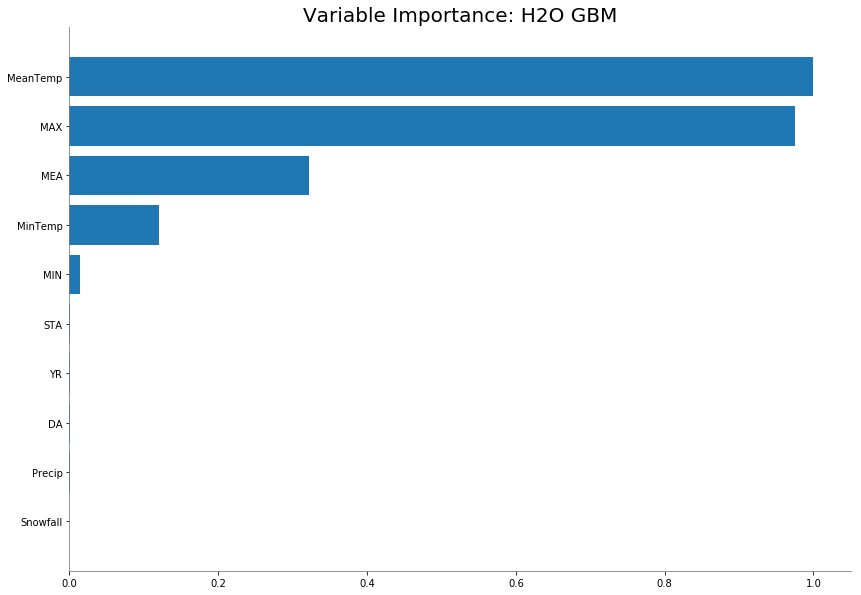

In [78]:
mod_best.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


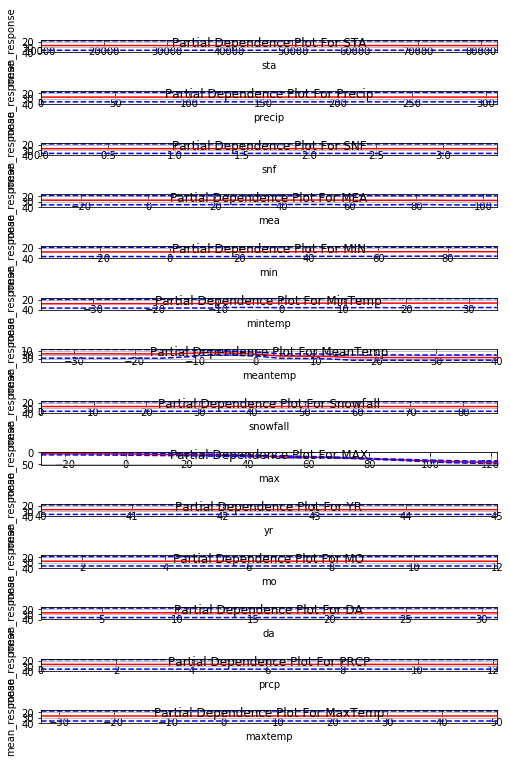

In [79]:
aml.leader.partial_plot(data=df, cols=df.columns)
plt.show()

In [75]:
# Clean up
os.chdir(server_path)

In [76]:
h2o.cluster().shutdown()

H2O session _sid_9c13 closed.
